# 🟥 Tarea

## Introducción

Si tenemos un etiquetado ground truth podemos usar métricas que comparan entre agrupamientos. Algunas de estas métricas suelen usarse en tareas de clustering. Algunos ejemplos son:

1. [Rand Index **RI**](https://scikit-learn.org/stable/modules/clustering.html#rand-index)
2. [Mutual Information based scores **MI**](https://scikit-learn.org/stable/modules/clustering.html#mutual-information-based-scores)
3. [Homogeneity, completeness and V-measure **HCV**](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)

## Ejercicios

Vamos a realizar la tarea de topic modeling usando el corpus `20newsgroups`

**1. Usando LDA obten 20 tópicos, mide el desempeño usando una métrica de cada uno de los 3 grupos descritos anteriormentes (RI, MI, HCV). También mide el desempeño usando la coherencia.**

In [1]:
#pip install gensim

In [2]:
# Importar librerías
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import numpy as np

In [3]:
# Descargar recursos de NLTK si es necesario
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jcbar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jcbar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Cargar el corpus 20newsgroups
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [5]:
# Preprocesar y tokenizar el texto
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Tokenizar el texto y eliminar stop words
    tokens = word_tokenize(text.lower())
    return [word for word in tokens if word.isalpha() and word not in stop_words]

# Aplicar el preprocesamiento al corpus
texts = [preprocess(doc) for doc in newsgroups.data]

# Filtrar documentos vacíos
texts = [doc for doc in texts if len(doc) > 0]

In [6]:
# Crear el diccionario después de preprocesar los textos
dictionary = corpora.Dictionary(texts)  # A cada palabra se le asigna un ID único (word_id)

# Crear el corpus para Gensim
corpus_gensim = [dictionary.doc2bow(text) for text in texts]  # Cada word_id se asocia con el número de veces que aparace en cada doc

# Podemos probar distintos tamaños de muestra del corpus para acelerar el proceso
sample_size = 18291 
corpus_sample = corpus_gensim[:sample_size]
texts_sample = texts[:sample_size]

In [7]:
# Entrenar el modelo LDA para obtener 20 tópicos
lda_model = LdaModel(corpus=corpus_sample, num_topics=20, id2word=dictionary, passes=5)

# Obtener el tópico más probable para cada documento
lda_topics = [lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in corpus_sample]
predicted_topics = [max(doc, key=lambda x: x[1])[0] for doc in lda_topics]

# Obtener las etiquetas reales del conjunto 20newsgroups
true_labels = newsgroups.target[:sample_size]

Calcular las métricas

In [8]:
# RI (Similitud entre clusters generados por LDA y etiquetas reales)
rand_index = adjusted_rand_score(true_labels, predicted_topics) # Valores de 0 (mal desempeño) a 1 (buen desempeño)

# MI (Dependencia entre las etiquetas reales y los tópicos generados)
mutual_info = normalized_mutual_info_score(true_labels, predicted_topics)

# Homogeneity (Evalúa si los docs dentro de un cluster tienen la misma etiqueta)
# Completeness (Evalúa si todos los docs de una categoría específica están en el mismo cluster)   
# V-Measue (Media armónica de Homogeneity y Completeness)
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, predicted_topics)

# Coherencia (Mide la consistencia semántica de los temeas generados. Un valor alto indica que las palabras en un mismo tópico tienden a aparecer juntas en los docs)
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_sample, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()

In [9]:
# Mostrar los resultados
print(f"Rand Index (RI): {round(rand_index, 5)}")
print(f"Mutual Information (MI): {round(mutual_info, 5)}")
print(f"Homogeneity: {round(homogeneity, 5)}")
print(f"Completeness: {round(completeness, 5)}")
print(f"V-measure: {round(v_measure, 5)}")
print(f"Coherencia del modelo LDA: {round(coherence_lda, 5)}")

Rand Index (RI): 6e-05
Mutual Information (MI): 0.00383
Homogeneity: 0.00344
Completeness: 0.00433
V-measure: 0.00383
Coherencia del modelo LDA: -3.50724


**2. Usando LSA obten 20 tópicos, mide el desempeño usando una métrica de cada uno de los 3 grupos descritos anteriormentes (RI, MI, HCV). También mide el desempeño usando la coherencia.**

In [11]:
# Importar librerías
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

Preprocesamiento del texto

In [12]:
# Función de preprocesamiento
def preprocess(text):
    return [word for word in text.lower().split() if word.isalpha()]

# Preprocesar y tokenizar el texto
texts_sample = [preprocess(doc) for doc in newsgroups.data[:sample_size]]

Crear el modelo de LSA (Latent Semantic Analysis) usando TruncatedSVD

In [13]:
# Crear un TfidfVectorizer para LSA
lsa_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_tfidf_lsa = lsa_vectorizer.fit_transform(newsgroups.data[:sample_size])

# Crear el modelo de LSA usando TruncatedSVD
n_topics = 20  # Número de tópicos que queremos obtener
svd_model = TruncatedSVD(n_components=n_topics)
lsa_model = make_pipeline(svd_model, Normalizer(copy=False))

# Aplicar el modelo LSA
X_lsa = lsa_model.fit_transform(X_tfidf_lsa)

# Asignar el tópico más relevante a cada documento (el componente con mayor valor)
predicted_topics_lsa = X_lsa.argmax(axis=1)

# Obtener las etiquetas reales de los documentos
true_labels = newsgroups.target[:sample_size]

Calcular las métricas

In [14]:
# RI
rand_index_lsa = adjusted_rand_score(true_labels, predicted_topics_lsa)

# MI
mutual_info_lsa = normalized_mutual_info_score(true_labels, predicted_topics_lsa)

# HCV
homogeneity_lsa, completeness_lsa, v_measure_lsa = homogeneity_completeness_v_measure(true_labels, predicted_topics_lsa)

In [15]:
# Evaluar la coherencia de los tópicos LSA

# Crear el diccionario y corpus de Gensim para la coherencia
dictionary_lsa = corpora.Dictionary(texts_sample)
corpus_lsa = [dictionary_lsa.doc2bow(text) for text in texts_sample]

# Convertir los tópicos de LSA a formato legible para Gensim
terms_lsa = lsa_vectorizer.get_feature_names_out()
topics_lsa_gensim = [[terms_lsa[i] for i in topic.argsort()[:-11:-1]] for topic in svd_model.components_]

# Calcular la coherencia
coherence_model_lsa = CoherenceModel(topics=topics_lsa_gensim, texts=texts_sample, dictionary=dictionary_lsa, coherence='u_mass')
coherence_lsa = coherence_model_lsa.get_coherence()

In [16]:
# Mostrar todos los resultados en la misma celda
print(f"Rand Index (RI) LSA: {round(rand_index_lsa, 5)}")
print(f"Mutual Information (MI) LSA: {round(mutual_info_lsa, 5)}")
print(f"Homogeneity LSA: {round(homogeneity_lsa, 5)}")
print(f"Completeness LSA: {round(completeness_lsa, 5)}")
print(f"V-measure LSA: {round(v_measure_lsa, 5)}")
print(f"Coherencia del modelo LSA: {round(coherence_lsa, 5)}")

Rand Index (RI) LSA: 0.00657
Mutual Information (MI) LSA: 0.15488
Homogeneity LSA: 0.11172
Completeness LSA: 0.25242
V-measure LSA: 0.15488
Coherencia del modelo LSA: -5.22667


**3. Usando un algoritmo de clustering donde se especifique el número de clusters, obtener 20 clusters que, idealmente, representen los tópicos. El algoritmo de clustering lo aplicaras a las representaciones BOW o TF-IDF. Escoge la que mejor desempeño tenga de acuerdo a alguna de las métricas de los 3 grupos anteriores (RI, MI, HCV).**

In [18]:
from sklearn.cluster import KMeans

# Función para almacenar y mostrar los resultados de clustering
def evaluar_clustering(predicted_clusters, metodo, vectorizacion):
    # Rand Index (RI)
    rand_index = adjusted_rand_score(newsgroups.target[:sample_size], predicted_clusters)

    # Mutual Information (MI)
    mutual_info = normalized_mutual_info_score(newsgroups.target[:sample_size], predicted_clusters)

    # Homogeneity, Completeness, V-measure (HCV)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(newsgroups.target[:sample_size], predicted_clusters)

    # Mostrar las métricas
    print(f"Resultados {metodo} ({vectorizacion}):\n")
    print(f"Rand Index (RI): {round(rand_index, 5)}")
    print(f"Mutual Information (MI): {round(mutual_info, 5)}")
    print(f"Homogeneity: {round(homogeneity, 5)}")
    print(f"Completeness: {round(completeness, 5)}")
    print(f"V-measure: {round(v_measure, 5)}\n")

Primero lo hacemos TF-IDF

In [19]:
# Clustering con TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Definir el vectorizador TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_tfidf = vectorizer_tfidf.fit_transform(newsgroups.data[:sample_size])

# Aplicar KMeans con 20 clusters
kmeans_tfidf = KMeans(n_clusters=20, random_state=0)
kmeans_tfidf.fit(X_tfidf)

# Obtener las predicciones de los clusters
predicted_clusters_tfidf = kmeans_tfidf.labels_

# Evaluar KMeans con TF-IDF
evaluar_clustering(predicted_clusters_tfidf, "KMeans", "TF-IDF")

Resultados KMeans (TF-IDF):

Rand Index (RI): 0.05687
Mutual Information (MI): 0.30897
Homogeneity: 0.27269
Completeness: 0.35637
V-measure: 0.30897



Ahora lo hacemos con BOW 

In [20]:
# Clustering con BOW
from sklearn.feature_extraction.text import CountVectorizer

# Definir el vectorizador BOW
vectorizer_bow = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_bow = vectorizer_bow.fit_transform(newsgroups.data[:sample_size])

# Aplicar KMeans con 20 clusters
kmeans_bow = KMeans(n_clusters=20, random_state=0)
kmeans_bow.fit(X_bow)

# Obtener las predicciones de los clusters
predicted_clusters_bow = kmeans_bow.labels_

# Evaluar KMeans con BOW
evaluar_clustering(predicted_clusters_bow, "KMeans", "BOW")

Resultados KMeans (BOW):

Rand Index (RI): 0.0
Mutual Information (MI): 0.0044
Homogeneity: 0.00222
Completeness: 0.25727
V-measure: 0.0044



**4. En cada una de las 3 estrategias haz una exploración manual de algunos documentos.**

Primero analizamos los datos originales

In [21]:
# Palabras clave de los tópicos originales

# Obtener las etiquetas únicas del conjunto de datos
categories = newsgroups.target_names
n_categories = len(categories)

# Crear un diccionario que almacenará las palabras clave de cada categoría
category_keywords = {}

# Para los tópicos originales, usamos un segundo vectorizer
original_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)

# Iterar por cada categoría para obtener sus documentos
for category_id, category_name in enumerate(categories):
    # Filtrar los documentos que pertenecen a esta categoría
    category_docs = [newsgroups.data[i] for i in range(len(newsgroups.data)) if newsgroups.target[i] == category_id]
    
    # Calcular la matriz TF-IDF para los documentos de esta categoría
    tfidf_matrix = original_vectorizer.fit_transform(category_docs)
    
    # Extraer las palabras con mayor TF-IDF
    tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
    top_word_indices = tfidf_scores.argsort()[::-1][:10]  # Obtener los 10 términos más representativos
    top_words = [original_vectorizer.get_feature_names_out()[i] for i in top_word_indices]
    
    # Guardar las palabras clave para la categoría actual
    category_keywords[category_id] = top_words

# Mostrar las palabras clave extraídas por categoría
print("\n\nPalabras clave por tópicos originales:\n")
for category_id, words in category_keywords.items():
    print(f"{categories[category_id]}: {words}")



Palabras clave por tópicos originales:

alt.atheism: ['god', 'don', 'people', 'think', 'just', 'say', 'does', 'religion', 'know', 'believe']
comp.graphics: ['graphics', 'thanks', 'know', 'image', 'does', 'file', 'like', 'files', 'program', 'format']
comp.os.ms-windows.misc: ['windows', 'file', 'dos', 'use', 'thanks', 'know', 'problem', 'like', 'files', 'program']
comp.sys.ibm.pc.hardware: ['drive', 'scsi', 'card', 'thanks', 'ide', 'know', 'bus', 'does', 'use', 'controller']
comp.sys.mac.hardware: ['mac', 'apple', 'drive', 'know', 'does', 'thanks', 'monitor', 'just', 'like', 'problem']
comp.windows.x: ['window', 'use', 'server', 'thanks', 'motif', 'like', 'windows', 'know', 'does', 'using']
misc.forsale: ['00', 'sale', 'new', 'offer', 'shipping', 'drive', 'mail', 'condition', 'email', 'price']
rec.autos: ['car', 'like', 'just', 'cars', 'know', 'new', 'good', 'don', 'engine', 'think']
rec.motorcycles: ['bike', 'like', 'just', 'don', 'know', 'dod', 've', 'ride', 'think', 'good']
rec.spo

Analizamos los tópicos identificados por LDA

In [22]:
# Mostrar las palabras clave de los tópicos generados por LDA
num_topics = 20
top_words_per_topic = 10  # Cantidad de palabras más relevantes por tópico

print("\n\nPalabras clave por tópicos LDA:\n")
for i, topic in lda_model.show_topics(num_topics=num_topics, num_words=top_words_per_topic, formatted=False):
    print(f"Tópico {i}: {[word for word, prob in topic]}")



Palabras clave por tópicos LDA:

Tópico 0: ['government', 'people', 'law', 'children', 'rights', 'gun', 'fbi', 'would', 'police', 'fire']
Tópico 1: ['key', 'encryption', 'chip', 'keys', 'use', 'government', 'clipper', 'security', 'privacy', 'technology']
Tópico 2: ['team', 'game', 'games', 'season', 'play', 'hockey', 'league', 'players', 'teams', 'win']
Tópico 3: ['x', 'fpu', 'c', 'vram', 'entry', 'output', 'file', 'indicators', 'int', 'return']
Tópico 4: ['one', 'get', 'car', 'like', 'would', 'new', 'good', 'much', 'also', 'used']
Tópico 5: ['university', 'research', 'center', 'volume', 'page', 'turkish', 'new', 'history', 'newsletter', 'turkey']
Tópico 6: ['israel', 'jews', 'israeli', 'jewish', 'arab', 'armenians', 'armenian', 'war', 'soldiers', 'killed']
Tópico 7: ['phone', 'lc', 'latch', 'speakers', 'midi', 'wave', 'cross', 'cellular', 'isles', 'morgan']
Tópico 8: ['one', 'get', 'back', 'time', 'got', 'year', 'last', 'first', 'go', 'said']
Tópico 9: ['image', 'file', 'files', 'so

Analizamos los tópicos identificados por LSA

In [23]:
# Mostrar palabras clave de los tópicos generados por LSA
print("\n\nPalabras clave por tópicos LSA:\n")
for i, topic in enumerate(svd_model.components_):
    top_words = [terms_lsa[i] for i in topic.argsort()[:-11:-1]]
    print(f"Tópico {i}: {top_words}")



Palabras clave por tópicos LSA:

Tópico 0: ['don', 'just', 'know', 'like', 'people', 'think', 'does', 'use', 'time', 'good']
Tópico 1: ['windows', 'thanks', 'drive', 'card', 'dos', 'file', 'pc', 'software', 'scsi', 'program']
Tópico 2: ['god', 'jesus', 'windows', 'does', 'bible', 'christ', 'thanks', 'faith', 'christian', 'dos']
Tópico 3: ['drive', 'scsi', 'god', 'ide', 'card', 'controller', 'hard', 'drives', 'disk', 'game']
Tópico 4: ['drive', 'key', 'scsi', 'chip', 'government', 'encryption', 'clipper', 'keys', 'law', 'people']
Tópico 5: ['windows', 'dos', 'file', 'think', 'problem', 'drive', 'os', 'window', 'run', 'ms']
Tópico 6: ['00', 'god', 'key', '10', 'game', 'edu', 'jesus', 'chip', '15', '20']
Tópico 7: ['edu', '00', 'people', 'armenian', 'geb', 'dsl', 'n3jxp', 'chastity', 'cadre', 'surrender']
Tópico 8: ['geb', 'pitt', 'dsl', 'cadre', 'n3jxp', 'chastity', 'skepticism', 'intellect', 'edu', 'shameful']
Tópico 9: ['car', 'bike', 'just', 'good', 've', 'god', '00', 'cars', 'engin

Inspeccionamos los clusters

In [24]:
# Asegúrate de tener los términos del TF-IDF almacenados en vectorizer_tfidf
terms_tfidf = vectorizer_tfidf.get_feature_names_out()

# Obtener las 10 palabras clave más importantes de cada cluster basado en los centros de los clusters de KMeans con TF-IDF
n_clusters = 20  # Número de clusters

print("\nPalabras clave por cluster (TF-IDF):\n")
for i in range(n_clusters):
    # Obtener el centro del cluster i
    cluster_center = kmeans_tfidf.cluster_centers_[i]
    
    # Obtener los índices de las 10 palabras más representativas para el cluster
    top_words_indices = cluster_center.argsort()[:-11:-1]  # Obtener los 10 valores más altos (las palabras más relevantes)
    
    # Mapear esos índices a las palabras
    top_words = [terms_tfidf[index] for index in top_words_indices]
    
    # Mostrar las palabras clave del cluster
    print(f"Cluster {i}: {top_words}")



Palabras clave por cluster (TF-IDF):

Cluster 0: ['dsl', 'n3jxp', 'cadre', 'chastity', 'geb', 'shameful', 'intellect', 'skepticism', 'pitt', 'surrender']
Cluster 1: ['like', 'edu', 'just', 'does', 'new', 'good', 'use', 'know', 'used', 'time']
Cluster 2: ['game', 'games', 'baseball', 'espn', 'hockey', 'team', 'year', 'season', 'play', 'win']
Cluster 3: ['car', 'bike', 'cars', 'engine', 'miles', 'just', 'oil', 'like', 'new', 'ride']
Cluster 4: ['mary', 'shafer', 'dryden', 'insisting', 'ames', 'balls', 'perfect', 'safety', 'nasa', 'god']
Cluster 5: ['thanks', 'mail', 'advance', 'know', 'hi', 'does', 'info', 'email', 'address', 'looking']
Cluster 6: ['card', 'monitor', 'apple', 'mac', 'video', 'modem', 'board', 'use', 'bus', 'port']
Cluster 7: ['file', 'window', 'files', 'program', 'server', 'use', 'application', 'format', 'motif', 'display']
Cluster 8: ['drivers', 'card', 'driver', 'windows', 'diamond', 'version', 'ati', 'ftp', 'video', 'cica']
Cluster 9: ['windows', 'dos', 'ms', 'os', '

**¿Parece haber coherencia?**

En general, todos los métodos muestran cierta coherencia en los tópicos o clusters generados, especialmente en temas bien definidos como política, religión, tecnología y deportes. Sin embargo, también es común encontrar tópicos menos coherentes que incluyen palabras muy generales o que no parecen estar claramente relacionadas con un tema específico.

LDA muestra una mayor coherencia en tópicos como política y religión, con palabras clave que parecen estar claramente relacionadas. Sin embargo, algunos tópicos son más difíciles de interpretar y contienen palabras que no encajan tan bien con el resto del grupo. LSA, por su parte, genera buenos tópicos en áreas como tecnología y deportes, pero a menudo mezcla temas, lo que dificulta la diferenciación de los mismos. En algunos casos, palabras de diferentes dominios (como religión y tecnología) aparecen en un mismo tópico, reduciendo su claridad. KMeans con TF-IDF también presenta coherencia en ciertos temas específicos, como hardware y religión, pero en otros clusters, las palabras no están tan bien agrupadas, lo que resulta en clusters más dispersos y difíciles de interpretar.

En conclusión, sí parece haber coherencia en varios de los tópicos y clusters generados, pero todos los enfoques presentan desafíos en la separación clara de ciertos temas, especialmente cuando hay términos muy generales o cuando los temas se mezclan en los documentos.

**5. En cada una de las 3 estrategias haz una nube de palabras por cada tópico.**

Nube de palabras por tópico (LDA):


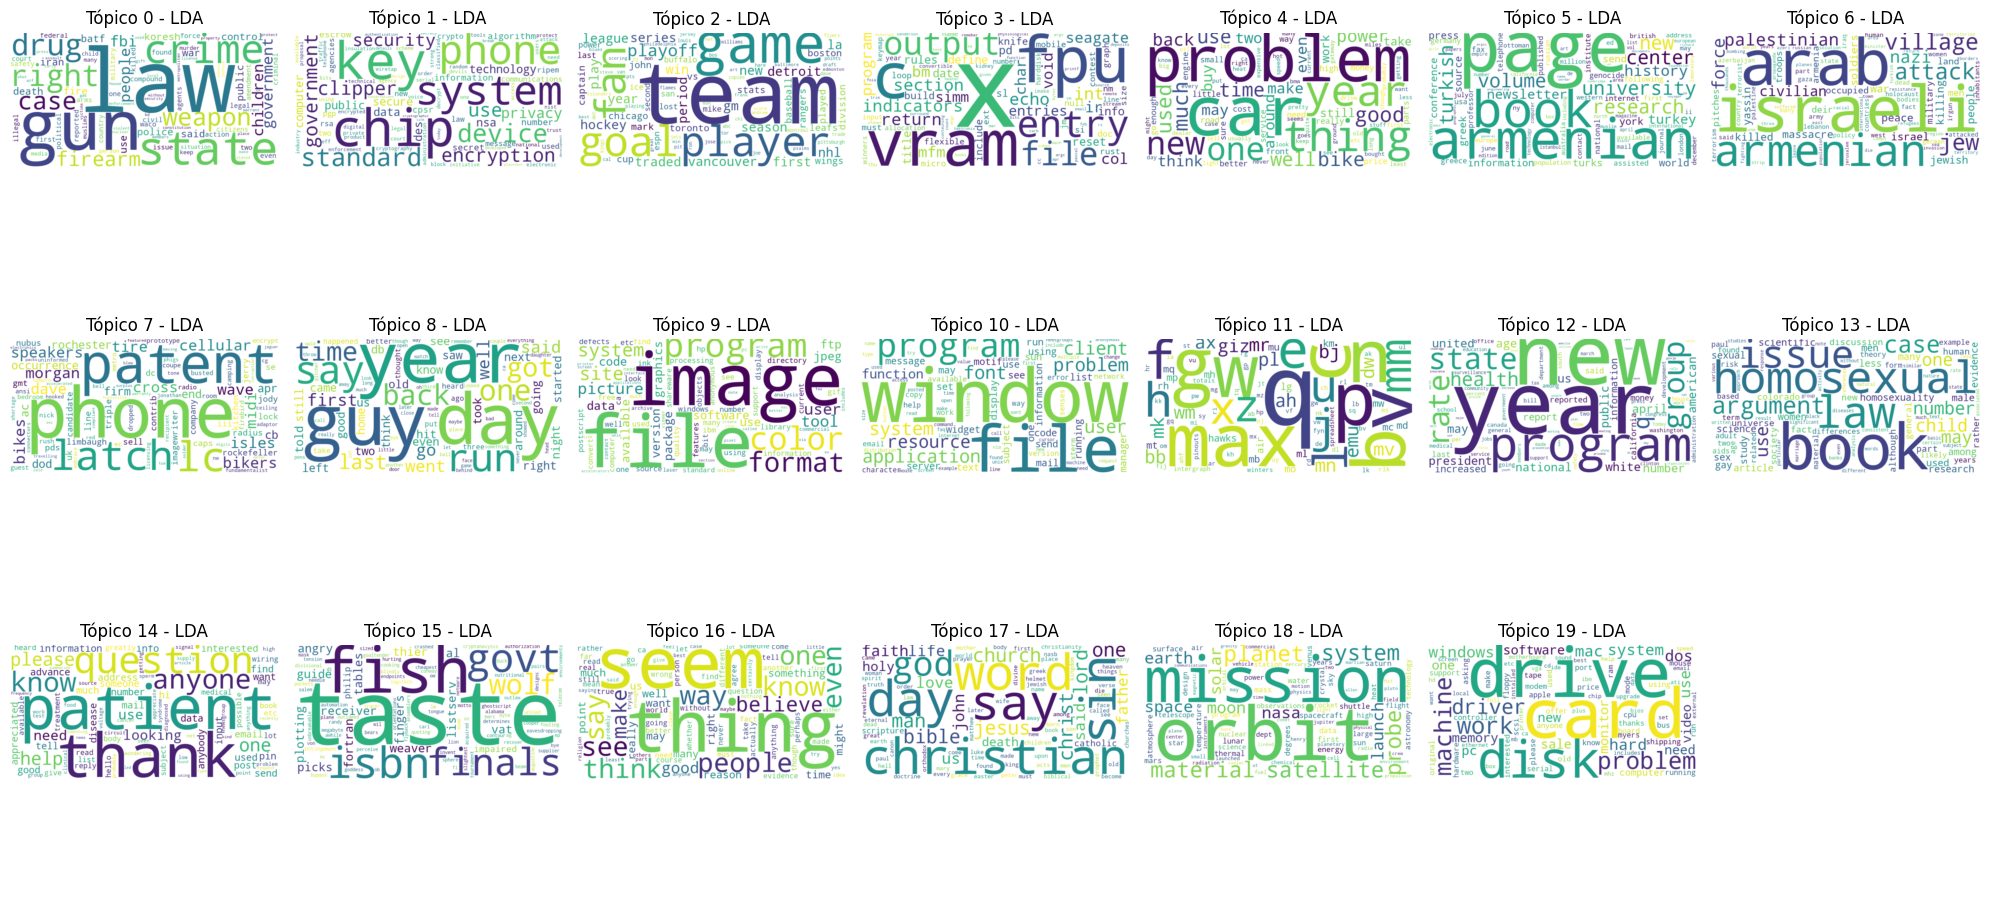

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Función para generar una nube de palabras
def generar_nube_palabras_subfigura(palabras, ax, titulo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(palabras))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(titulo, fontsize=12)
    ax.axis("off")

### Nube de palabras para LDA ###
print("Nube de palabras por tópico (LDA):")

# Definir una cuadrícula de 3 filas y 7 columnas (21 espacios)
fig, axs = plt.subplots(3, 7, figsize=(20, 10))

for i, topic in enumerate(lda_model.show_topics(num_topics=20, num_words=100, formatted=False)):
    palabras_lda = [word for word, prob in topic[1]]  # Extraer las palabras de cada tópico
    fila = i // 7  # Definir la fila de la subfigura
    columna = i % 7  # Definir la columna de la subfigura
    generar_nube_palabras_subfigura(palabras_lda, axs[fila, columna], f"Tópico {i} - LDA")

# Ocultar el último subplot vacío
axs[-1, -1].axis("off")

# Ajustar la disposición y mostrar
plt.tight_layout()
plt.show()


Nube de palabras por tópico (LSA):


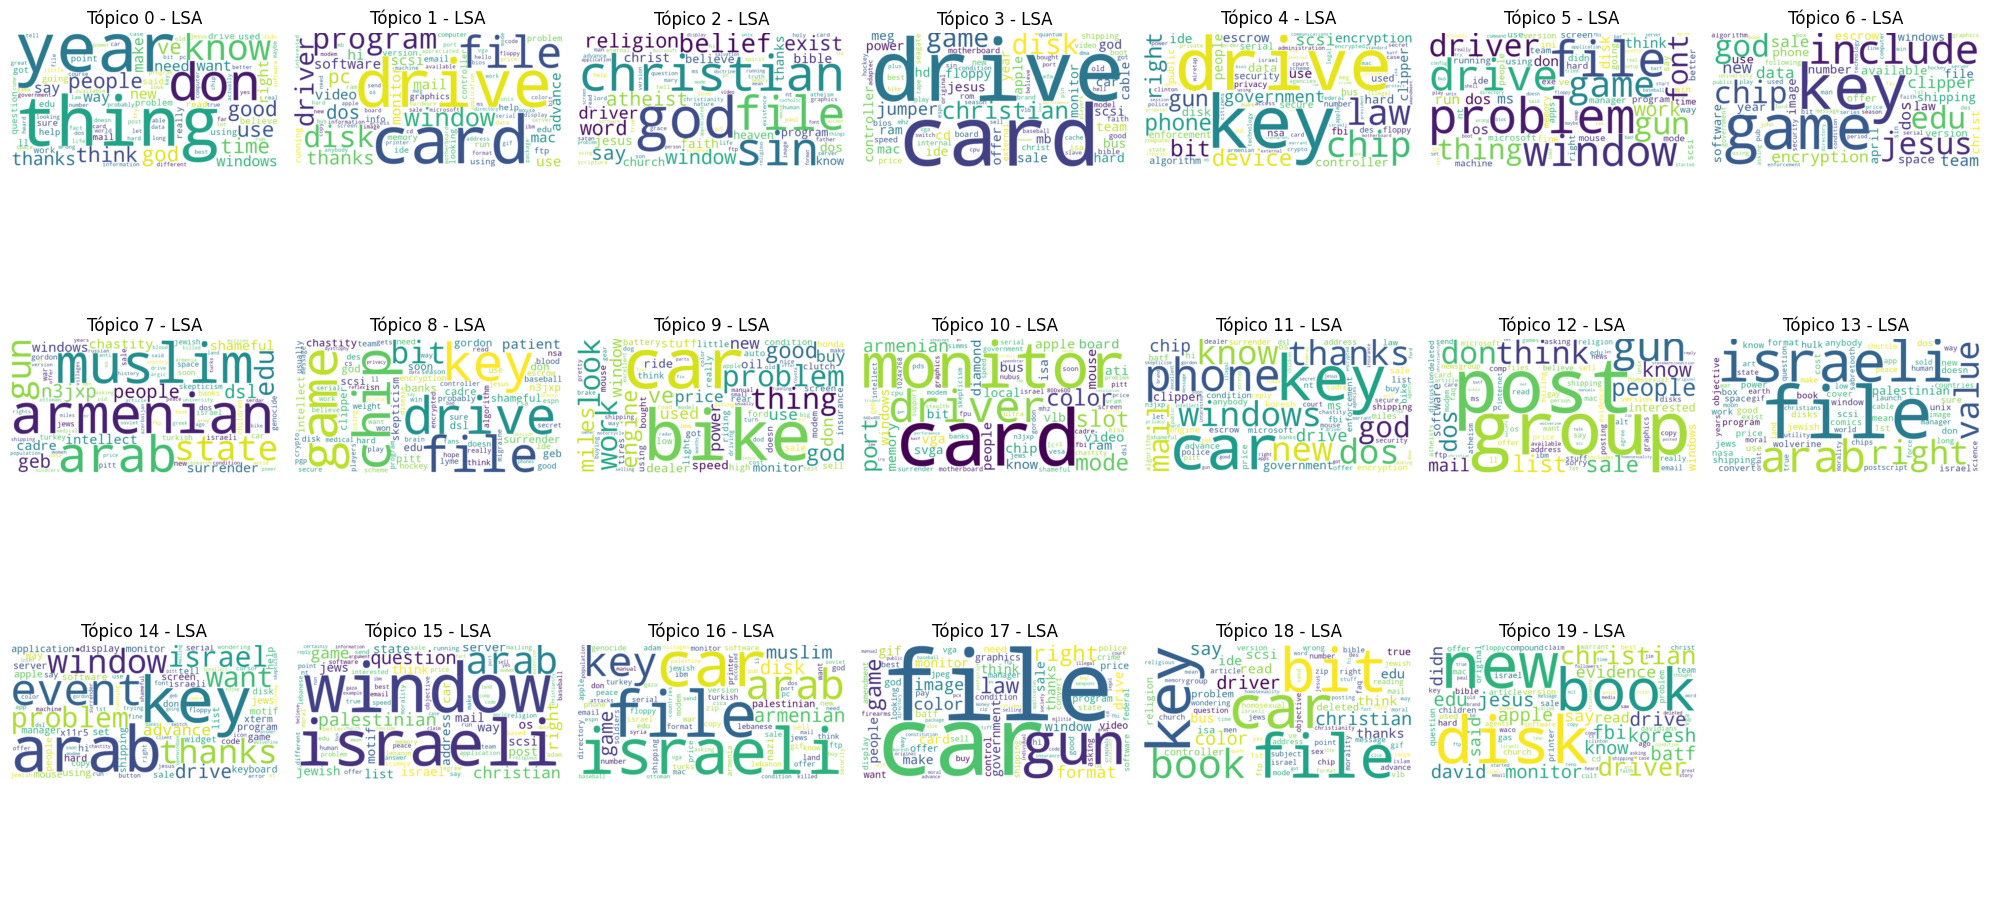

In [26]:
### Nube de palabras para LSA ###
print("Nube de palabras por tópico (LSA):")

fig, axs = plt.subplots(3, 7, figsize=(20, 10))  # Mismo formato de cuadrícula

for i, topic in enumerate(svd_model.components_):
    palabras_lsa = [terms_lsa[index] for index in topic.argsort()[:-101:-1]]  # Extraer las palabras más representativas
    fila = i // 7
    columna = i % 7
    generar_nube_palabras_subfigura(palabras_lsa, axs[fila, columna], f"Tópico {i} - LSA")

# Ocultar el último subplot vacío
axs[-1, -1].axis("off")

plt.tight_layout()
plt.show()

Nube de palabras por cluster (KMeans - TF-IDF):


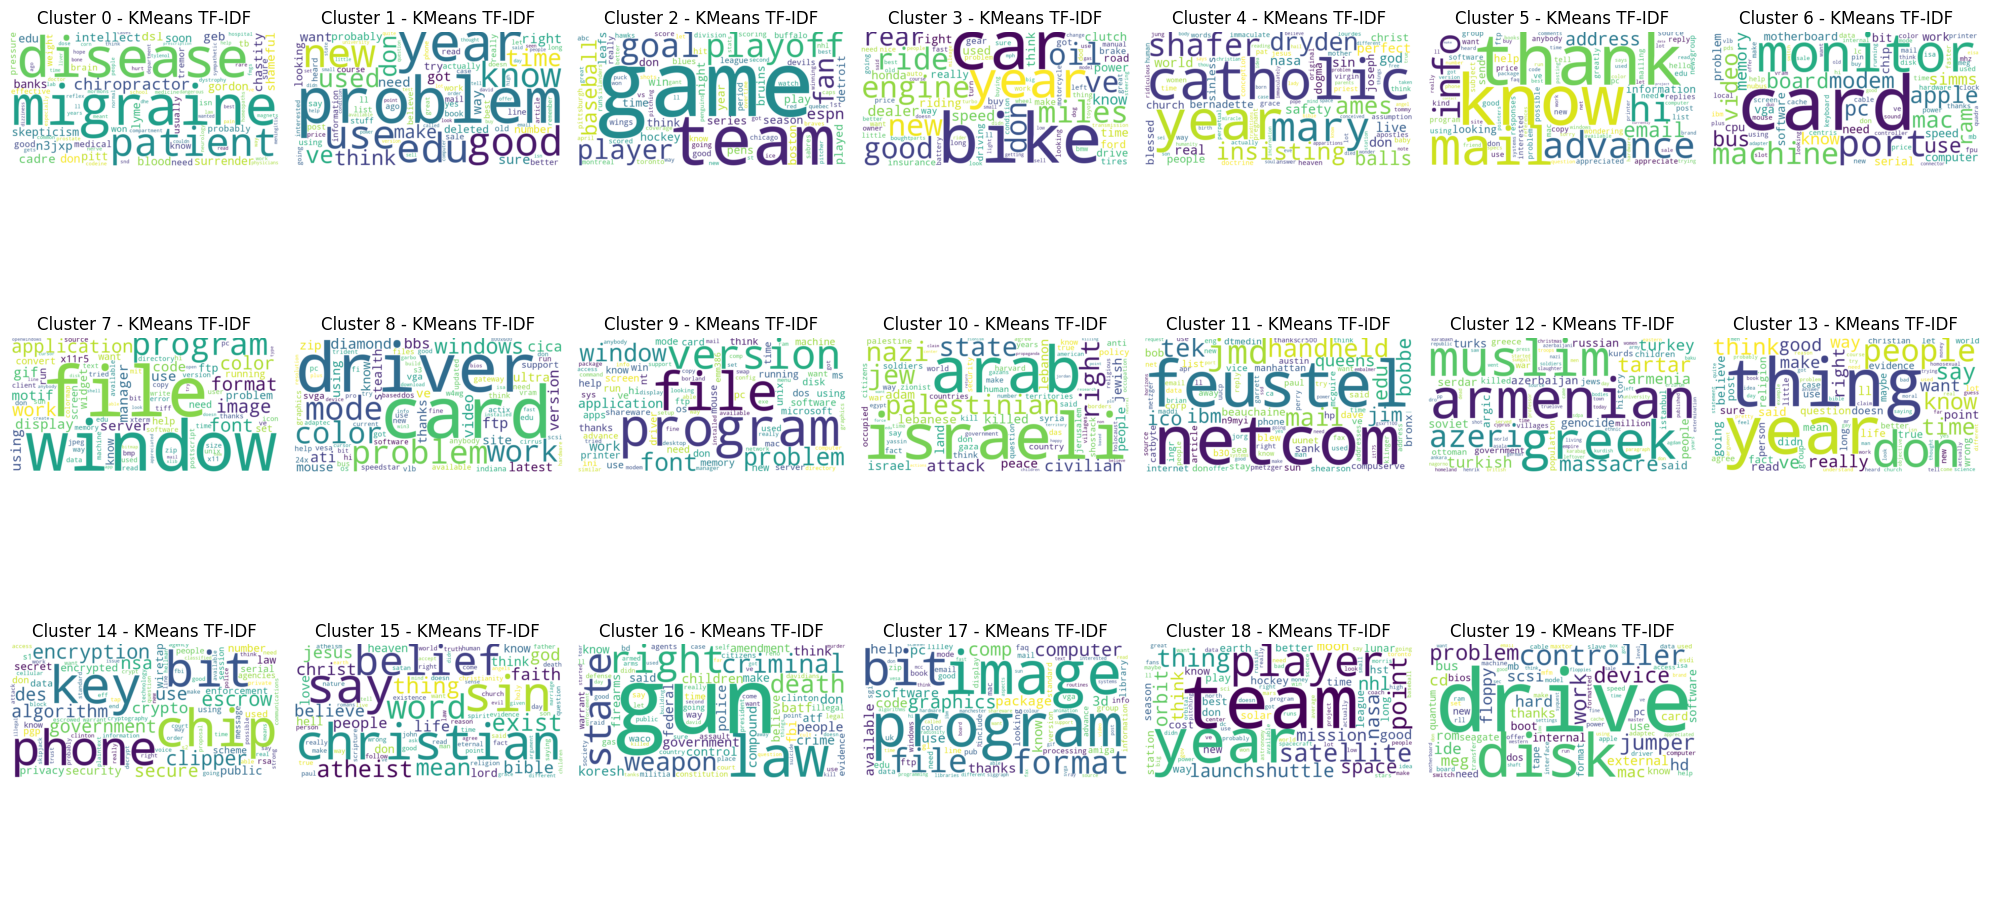

In [27]:
### Nube de palabras para KMeans con TF-IDF ###
print("Nube de palabras por cluster (KMeans - TF-IDF):")

fig, axs = plt.subplots(3, 7, figsize=(20, 10))  # Misma cuadrícula

for i in range(20):  # Para los 20 clusters
    cluster_center = kmeans_tfidf.cluster_centers_[i]
    palabras_tfidf = [terms_tfidf[index] for index in cluster_center.argsort()[:-101:-1]]  # Extraer las 100 palabras más importantes del cluster
    fila = i // 7
    columna = i % 7
    generar_nube_palabras_subfigura(palabras_tfidf, axs[fila, columna], f"Cluster {i} - KMeans TF-IDF")

# Ocultar el último subplot vacío
axs[-1, -1].axis("off")

plt.tight_layout()
plt.show()


**¿Parece haber coherencia en el vocabulario?**

**LDA:** 
LDA sigue mostrando la mayor coherencia en los tópicos generados, con palabras clave bien agrupadas en temas definidos como política (por ejemplo, Israel y el Medio Oriente), tecnología, y deportes. Aunque algunos tópicos contienen palabras más generales o menos relacionadas, en general, los temas son consistentes y diferenciados, lo que destaca la capacidad de LDA para generar grupos temáticos claros con menor ruido.

**LSA:**
LSA ofrece una coherencia media. Aunque algunos tópicos están bien definidos, se observa una mayor mezcla de conceptos en comparación con LDA. En varios casos, aparecen palabras de dominios diferentes en el mismo tópico, lo que dificulta la interpretación de los temas. Si bien LSA logra agrupar términos relacionados en ciertos temas, su precisión es menor que la de LDA debido a esta mezcla.

**KMeans (TF-IDF):**
KMeans con TF-IDF muestra coherencia en algunos clusters, particularmente en temas específicos como tecnología y política. Sin embargo, muchos clusters presentan una mayor dispersión de palabras clave, lo que reduce la claridad de los temas en comparación con LDA y, en menor medida, con LSA. Aunque algunos temas están bien agrupados, la coherencia general de KMeans es más baja debido a la mayor dispersión de conceptos.

**6. Con el mismo corpus obten el mejor número de tópicos usando LSA de acuerdo a las métricas:**
 
 * **Coherencia**

In [ ]:
# Preprocesamiento de texto
stop_words = stopwords.words('english')
def preprocess_text(texts):
    preprocessed_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        preprocessed_texts.append(tokens)
    return preprocessed_texts

texts = preprocess_text(newsgroups.data)

In [28]:
# Crear el diccionario y el corpus de gensim
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Aplicar TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(newsgroups.data)

# Función para calcular la coherencia de un modelo LSA dado un número de tópicos
def calculate_coherence_lsa(num_topics, X_tfidf, texts, dictionary):
    lsa_model = TruncatedSVD(n_components=num_topics)
    lsa_model.fit(X_tfidf)
    
    # Extraer los términos más importantes de los componentes (tópicos)
    topics = []
    for topic in lsa_model.components_:
        top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
        topics.append(top_words)
    
    # Usar CoherenceModel de Gensim para calcular la coherencia
    coherence_model_lsa = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence = coherence_model_lsa.get_coherence()
    
    return coherence

# Rango de tópicos a evaluar
topic_range = range(2, 21)
coherence_values = []

# Calcular la coherencia para cada número de tópicos
for num_topics in topic_range:
    coherence = calculate_coherence_lsa(num_topics, X_tfidf, texts, dictionary)
    coherence_values.append(coherence)

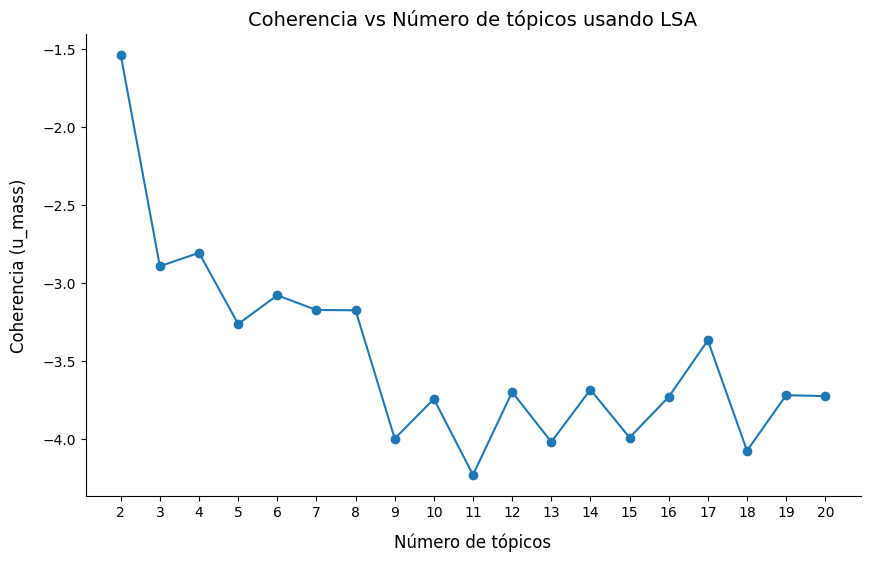

In [29]:
import matplotlib.pyplot as plt

# Generar la gráfica de coherencia con los ajustes solicitados
plt.figure(figsize=(10, 6))

# Gráfico con puntos marcados
plt.plot(topic_range, coherence_values, marker='o')

# Título y etiquetas
plt.title('Coherencia vs Número de tópicos usando LSA', fontsize=14)
plt.xlabel('Número de tópicos', fontsize=12, labelpad=10)
plt.ylabel('Coherencia (u_mass)', fontsize=12, labelpad=10)

# Asegurarnos de que el eje x muestra solo valores enteros
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar el grid de fondo
plt.grid(False)

# Eliminar los bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Mostrar la gráfica
plt.show()


 * **Alguna de los grupos RI, MI, HCV.**

In [ ]:
# Preprocesamiento
def preprocess(text):
    return [word for word in text.lower().split() if word.isalpha()]

# Sample size 
sample_size = len(newsgroups.data)  # Usamos todo el conjunto de datos

# Preprocesar y tokenizar el texto
texts_sample = [preprocess(doc) for doc in newsgroups.data[:sample_size]]

In [30]:
# Crear un TfidfVectorizer para LSA
lsa_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
X_tfidf_lsa = lsa_vectorizer.fit_transform(newsgroups.data[:sample_size])

# Función para calcular el Rand Index (RI) con LSA
def calculate_ri_lsa(num_topics, X_tfidf_lsa, true_labels):
    # Crear el modelo de LSA usando TruncatedSVD y normalización
    svd_model = TruncatedSVD(n_components=num_topics)
    lsa_model = make_pipeline(svd_model, Normalizer(copy=False))
    
    # Aplicar el modelo LSA
    X_lsa = lsa_model.fit_transform(X_tfidf_lsa)
    
    # Asignar el tópico más relevante a cada documento (el componente con mayor valor)
    predicted_topics_lsa = X_lsa.argmax(axis=1)
    
    # Calcular el Rand Index (RI)
    ri = adjusted_rand_score(true_labels, predicted_topics_lsa)
    
    return ri

# Obtener las etiquetas reales de los documentos
true_labels = newsgroups.target[:sample_size]

# Rango de tópicos a evaluar
topic_range = range(2, 21)
ri_values = []

# Calcular el RI para cada número de tópicos
for num_topics in topic_range:
    ri = calculate_ri_lsa(num_topics, X_tfidf_lsa, true_labels)
    ri_values.append(ri)

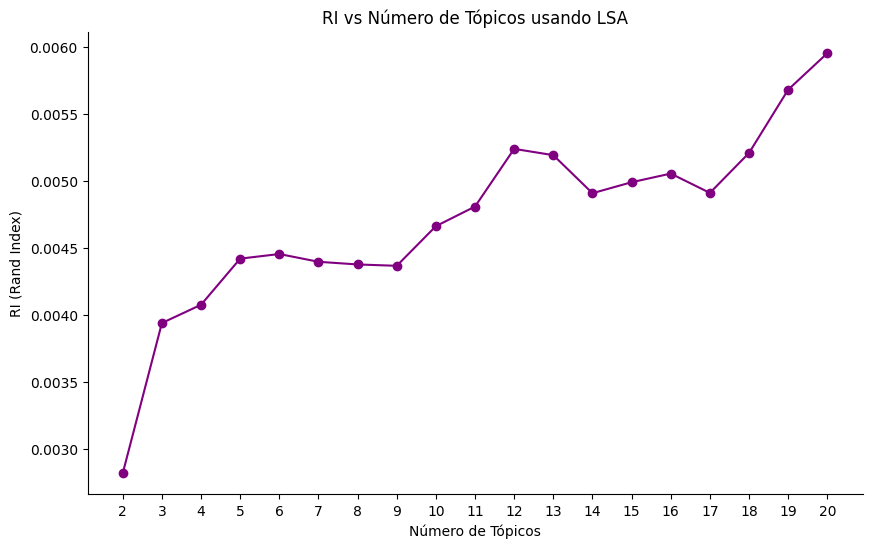

In [31]:
# Generar la gráfica de RI
plt.figure(figsize=(10, 6))
plt.plot(topic_range, ri_values, marker='o', color='purple')
plt.title('RI vs Número de Tópicos usando LSA')
plt.xlabel('Número de Tópicos')
plt.ylabel('RI (Rand Index)')
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

 * **Coherencia usando la similitud coseno entre embeddings.**

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

# Función para calcular la coherencia basada en la similitud coseno entre embeddings de LSA
def calculate_cosine_coherence_lsa(num_topics, X_tfidf_lsa):
    # Crear el modelo de LSA usando TruncatedSVD y normalización
    svd_model = TruncatedSVD(n_components=num_topics)
    lsa_model = make_pipeline(svd_model, Normalizer(copy=False))
    
    # Aplicar el modelo LSA para obtener los embeddings de los términos
    X_lsa = lsa_model.fit_transform(X_tfidf_lsa.T)  # Transponemos para obtener embeddings de términos
    
    # Calcular la similitud coseno entre los embeddings
    cosine_similarities = cosine_similarity(X_lsa)
    
    # Coherencia: Promediar las similitudes coseno entre los términos dentro de cada tópico
    avg_cosine_similarity = np.mean(cosine_similarities)
    
    return avg_cosine_similarity

# Rango de tópicos a evaluar
topic_range = range(2, 21)
cosine_coherence_values = []

# Calcular la coherencia usando la similitud coseno para cada número de tópicos
for num_topics in topic_range:
    cosine_coherence = calculate_cosine_coherence_lsa(num_topics, X_tfidf_lsa)
    cosine_coherence_values.append(cosine_coherence)

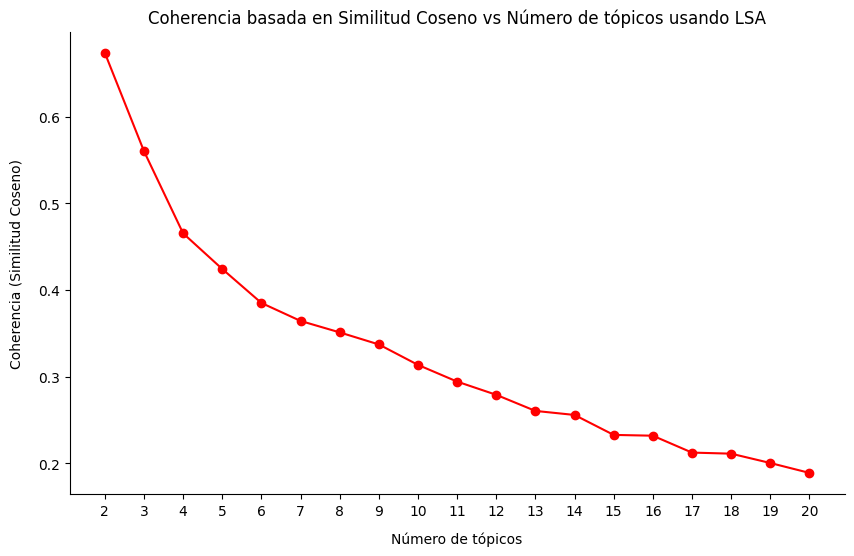

In [34]:
# Generar la gráfica de coherencia usando similitud coseno
plt.figure(figsize=(10, 6))
plt.plot(topic_range, cosine_coherence_values, marker='o', color='red')
plt.title('Coherencia basada en Similitud Coseno vs Número de tópicos usando LSA')
plt.xlabel('Número de tópicos', labelpad=10)
plt.ylabel('Coherencia (Similitud Coseno)', labelpad=10)
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

**7. Con el mismo corpus obten el mejor número de tópicos usando LDA de acuerdo a las métricas:**
 * **Coherencia.**

In [35]:
# Preprocesamiento de texto
def preprocess_text(texts):
    preprocessed_texts = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
        preprocessed_texts.append(tokens)
    return preprocessed_texts

# Preprocesar el corpus
texts = preprocess_text(newsgroups.data)

In [36]:
# Crear el diccionario y el corpus para Gensim
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Función para calcular la coherencia con LDA
def calculate_coherence_lda(num_topics, corpus, dictionary, texts):
    # Crear el modelo LDA
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
    
    # Calcular la coherencia usando CoherenceModel
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='u_mass')
    coherence = coherence_model_lda.get_coherence()
    
    return coherence

# Rango de tópicos a evaluar
topic_range = range(2, 21)
lda_coherence_values = []

# Calcular la coherencia para cada número de tópicos
for num_topics in topic_range:
    coherence = calculate_coherence_lda(num_topics, corpus, dictionary, texts)
    lda_coherence_values.append(coherence)

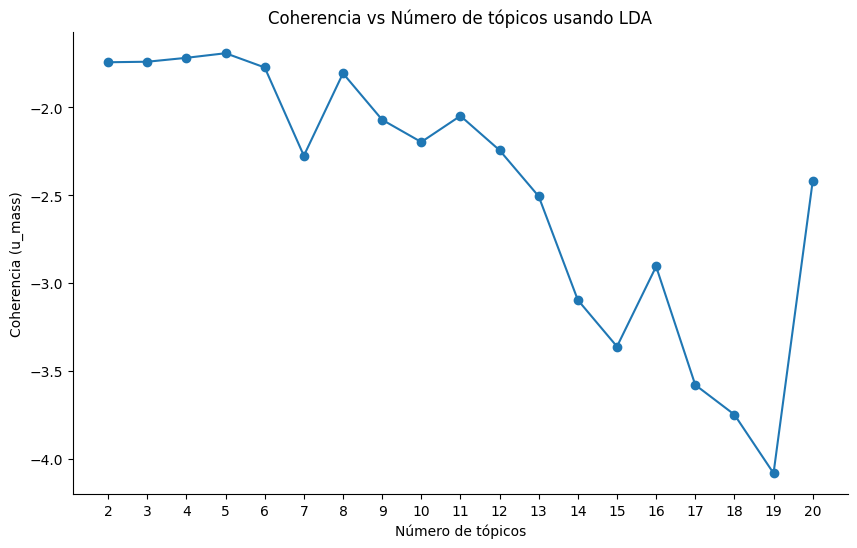

In [37]:
# Generar la gráfica de coherencia
plt.figure(figsize=(10, 6))
plt.plot(topic_range, lda_coherence_values, marker='o')
plt.title('Coherencia vs Número de tópicos usando LDA')
plt.xlabel('Número de tópicos')
plt.ylabel('Coherencia (u_mass)')
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

 * **Alguna de los grupos RI, MI, HCV.**

In [38]:
# Función para calcular RI para LDA
def calculate_ri_lda(num_topics, corpus, dictionary, true_labels):
    # Crear el modelo LDA
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
    
    # Obtener la asignación del tópico más relevante para cada documento
    predicted_topics_lda = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        # Asignar el tópico con mayor probabilidad
        predicted_topics_lda.append(max(topic_probs, key=lambda x: x[1])[0])
    
    # Calcular RI
    ri = adjusted_rand_score(true_labels, predicted_topics_lda)
    
    return ri

# Cargar las etiquetas verdaderas del corpus
true_labels = newsgroups.target

# Rango de tópicos a evaluar
topic_range = range(2, 21)
lda_ri_values = []

# Calcular el RI para cada número de tópicos
for num_topics in topic_range:
    ri = calculate_ri_lda(num_topics, corpus, dictionary, true_labels)
    lda_ri_values.append(ri)

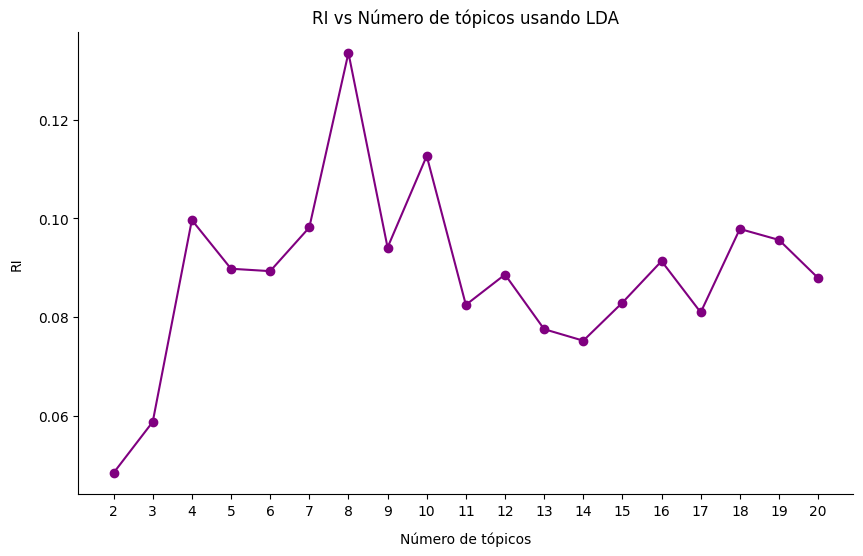

In [39]:
# Generar la gráfica de RI
plt.figure(figsize=(10, 6))
plt.plot(topic_range, lda_ri_values, marker='o', color='purple')
plt.title('RI vs Número de tópicos usando LDA')
plt.xlabel('Número de tópicos', labelpad=10)
plt.ylabel('RI', labelpad=10)
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

 * **Coherencia usando la similitud coseno entre embeddings.**

In [40]:
# Función para calcular la coherencia basada en la similitud coseno entre embeddings con LDA
def calculate_cosine_coherence_lda(num_topics, corpus, dictionary):
    # Crear el modelo LDA
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
    
    # Obtener los embeddings de los términos (matriz de tópicos y términos)
    topic_term_matrix = lda_model.get_topics()
    
    # Calcular la similitud coseno entre los embeddings de los términos
    cosine_similarities = cosine_similarity(topic_term_matrix)
    
    # Coherencia: Promediar las similitudes coseno entre los términos dentro de cada tópico
    avg_cosine_similarity = np.mean(cosine_similarities)
    
    return avg_cosine_similarity

# Rango de tópicos a evaluar
topic_range = range(2, 21)
lda_cosine_coherence_values = []

# Calcular la coherencia usando la similitud coseno para cada número de tópicos
for num_topics in topic_range:
    cosine_coherence = calculate_cosine_coherence_lda(num_topics, corpus, dictionary)
    lda_cosine_coherence_values.append(cosine_coherence)

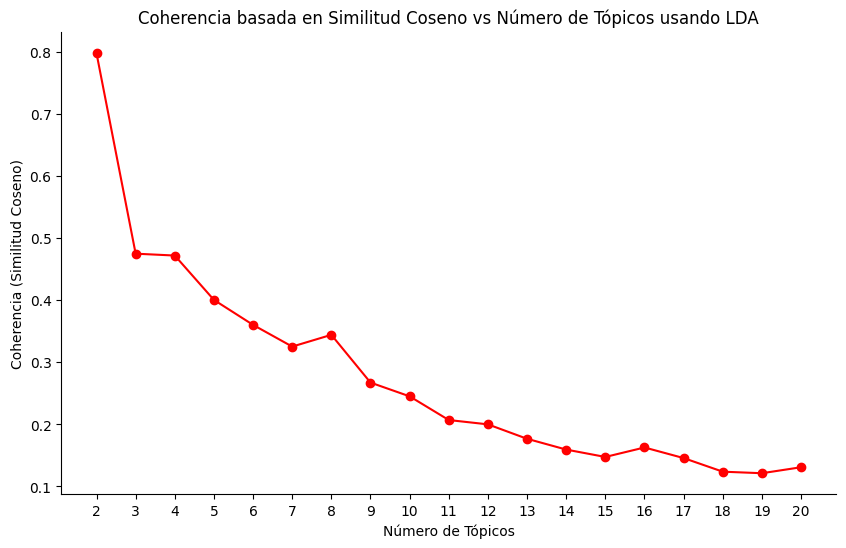

In [42]:
# Generar la gráfica de coherencia usando similitud coseno
plt.figure(figsize=(10, 6))
plt.plot(topic_range, lda_cosine_coherence_values, marker='o', color='red')
plt.title('Coherencia basada en Similitud Coseno vs Número de Tópicos usando LDA')
plt.xlabel('Número de Tópicos')
plt.ylabel('Coherencia (Similitud Coseno)')
plt.xticks(ticks=range(min(topic_range), max(topic_range) + 1, 1))

# Eliminar bordes derecho y superior
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()


## **Conclusiones**

**Redacta un pequeño texto respondiendo las siguientes preguntas.**

* **¿Cuál método te parece *mejor* en este corpus?**

Considerando los resultados obtenidos con las tres técnicas (LDA, LSA y KMeans con TF-IDF), el método que parece ser más adecuado para este corpus es LDA. Este modelo genera tópicos con palabras clave claramente relacionadas entre sí y que representan temas diferenciados, como los tópicos relacionados con política en el Medio Oriente o temas de tecnología. Las palabras clave dentro de los tópicos tienen menos ruido y más cohesión que en los otros métodos. En el caso de LSA, aunque también hay cierta coherencia en las agrupaciones, tiende a mezclar conceptos de diferentes dominios, lo que provoca menos claridad en la separación temática. Por otro lado, KMeans con TF-IDF ofrece resultados variables: algunos clusters son fáciles de interpretar, pero otros presentan una mayor dispersión en el vocabulario, lo que los hace más difíciles de entender. Además, las métricas de desempeño muestran que LDA ofrece una mejor combinación de coherencia y separación temática, mientras que LSA y KMeans tienden a ser más ruidosos. En términos generales, LDA es el método que mejor captura la estructura temática de este corpus, con mayor claridad y consistencia que los otros dos.

* **El hecho de tener las etiquetas reales de tópicos, ¿facilita la tarea?**

Tener las etiquetas reales proporciona una forma clara y directa de evaluar los modelos mediante métricas supervisadas como Rand Index o Mutual Information. Sin embargo, en tareas no supervisadas como el modelado de tópicos, no se espera que los modelos repliquen exactamente las categorías originales. De hecho, estos modelos pueden descubrir temas latentes que no coinciden necesariamente con las etiquetas predefinidas, pero que aún pueden ser coherentes y significativos.

Esto significa que las etiquetas son útiles para validar los modelos en cuanto a qué tan bien se alinean con los temas originales, pero no necesariamente son el único criterio para evaluar el éxito del modelo. Un buen modelo no supervisado puede crear nuevas categorías que, aunque no correspondan perfectamente a las etiquetas originales, revelen estructuras interesantes o variantes temáticas dentro de los datos que no habían sido categorizadas previamente.

* **¿Las diferentes métricas parecen ser coherentes entre ellas?**

En general, las métricas utilizadas (Rand Index, Mutual Information, Homogeneity, Completeness, V-measure, y Coherencia) muestran patrones coherentes entre sí, pero también reflejan las diferencias naturales entre lo que mide cada una. Por ejemplo, LDA generalmente mostró valores bajos en las métricas de homogeneidad y completitud, pero al mismo tiempo destacó por ofrecer mayor coherencia en la agrupación temática, lo que sugiere que aunque no logró clasificaciones precisas en comparación con las etiquetas originales, los temas generados son más comprensibles y semánticamente coherentes. LSA, por otro lado, tuvo valores más altos de Mutual Information y V-measure, lo que indica una mayor relación con las etiquetas reales, pero su coherencia fue más baja, evidenciando que los tópicos generados eran más difusos. En cuanto a KMeans con TF-IDF, mostró una mejoría en varias métricas (por ejemplo, Rand Index y Homogeneity), pero aún con una mayor dispersión temática en algunos clusters. Esto indica que, aunque algunas métricas estén alineadas, su interpretación depende del enfoque del análisis: si se busca coherencia semántica dentro de los tópicos o una mayor correspondencia con las etiquetas originales.